In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("클릭스트림 분석을 위한 라이브러리 로드 완료")


In [27]:
# 클릭스트림 데이터 분석을 위한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료!")


라이브러리 import 완료!


In [28]:
# 실제 데이터 로드
df = pd.read_csv(r'C:\Users\young\Downloads\38w__clickstream.csv')

# 컬럼명을 소문자로 변경
df.columns = [col.lower() for col in df.columns]

# event_dttm을 datetime 형식으로 변환
df['event_dttm'] = pd.to_datetime(df['event_dttm'])

print("=== 데이터 기본 정보 ===")
print(f"데이터 크기: {df.shape}")
print(f"컬럼명: {list(df.columns)}")
print(f"날짜 범위: {df['event_dt'].min()} ~ {df['event_dt'].max()}")
print(f"고유 사용자 수: {df['user_seq'].nunique()}")
print(f"이벤트 타입 수: {df['event_type'].nunique()}")

print("\n=== 데이터 미리보기 ===")
print(df.head(10))


=== 데이터 기본 정보 ===
데이터 크기: (548779, 5)
컬럼명: ['event_dt', 'user_seq', 'event_type', 'event_dttm', 'rn']
날짜 범위: 2025-09-08 ~ 2025-09-19
고유 사용자 수: 43181
이벤트 타입 수: 12

=== 데이터 미리보기 ===
     event_dt  user_seq event_type              event_dttm  rn
0  2025-09-08    9465.0       QUIZ 2025-09-08 18:35:12.554   5
1  2025-09-08    3527.0       QUIZ 2025-09-08 21:49:30.175   6
2  2025-09-08   26192.0       CARD 2025-09-08 18:36:20.229   4
3  2025-09-08  132495.0       QUIZ 2025-09-08 20:00:58.754   2
4  2025-09-08   60730.0       CARD 2025-09-08 22:20:14.074   5
5  2025-09-08  139154.0       CARD 2025-09-08 21:44:33.066   4
6  2025-09-09   38077.0    COUPANG 2025-09-09 05:29:48.784   3
7  2025-09-08   15370.0       CARD 2025-09-08 20:43:08.114   6
8  2025-09-08    1731.0       QUIZ 2025-09-08 17:16:18.337   9
9  2025-09-08   33270.0       QUIZ 2025-09-08 22:31:05.408   5


=== 이벤트 타입별 빈도 ===
event_type
WALK           131482
LOTTO_OTHER     93762
RAFFLE          77981
CHG             77981
QUIZ            61095
LOTTO_AD        38615
COUPANG         27448
CARD            26483
STRETCHING      11803
BUZZVILL         1832
LIKE              241
FOLLOW             56
Name: count, dtype: int64


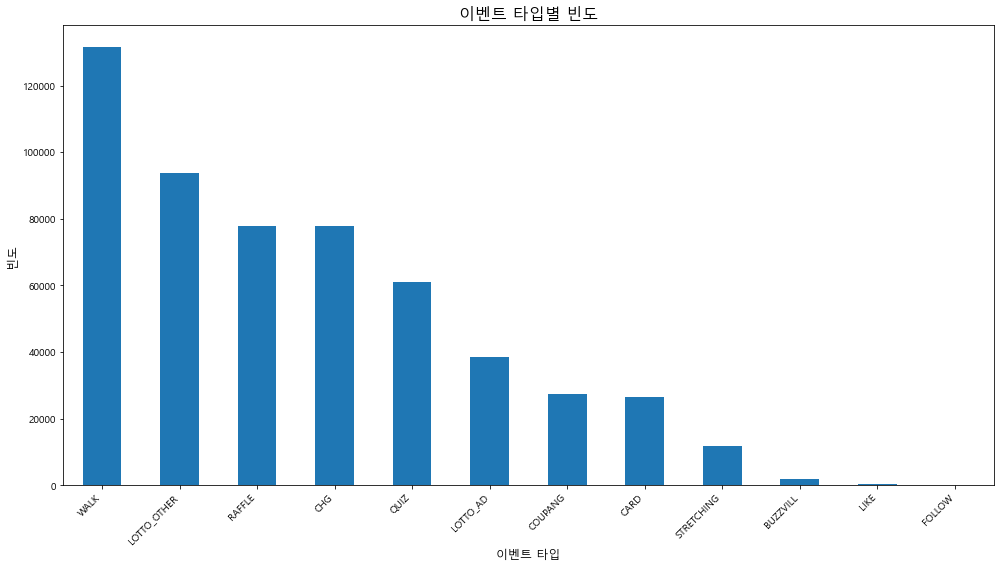


=== 상위 이벤트 비율 ===
1. WALK: 131,482회 (24.0%)
2. LOTTO_OTHER: 93,762회 (17.1%)
3. RAFFLE: 77,981회 (14.2%)
4. CHG: 77,981회 (14.2%)
5. QUIZ: 61,095회 (11.1%)


In [29]:
# 1. 기본 데이터 탐색
print("=== 이벤트 타입별 빈도 ===")
event_counts = df['event_type'].value_counts()
print(event_counts)

# 이벤트 타입별 빈도 시각화
plt.figure(figsize=(14, 8))
event_counts.plot(kind='bar')
plt.title('이벤트 타입별 빈도', fontsize=16)
plt.xlabel('이벤트 타입', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 상위 이벤트들의 비율 계산
print("\n=== 상위 이벤트 비율 ===")
total_events = len(df)
for i, (event, count) in enumerate(event_counts.head(5).items()):
    percentage = (count / total_events) * 100
    print(f"{i+1}. {event}: {count:,}회 ({percentage:.1f}%)")


=== 사용자별 시퀀스 분석 (날짜별 세션 분리) ===
총 세션 수: 162,558
고유 사용자 수: 43,181
평균 시퀀스 길이: 3.38
최대 시퀀스 길이: 12
최소 시퀀스 길이: 2


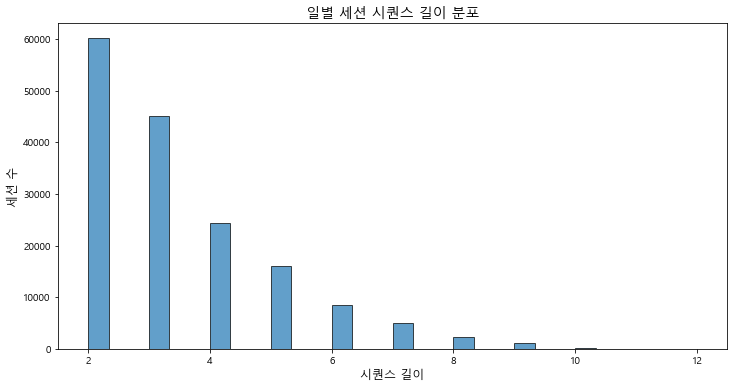


=== 시퀀스 길이 통계 ===
count    162558.000000
mean          3.375897
std           1.546608
min           2.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          12.000000
Name: sequence_length, dtype: float64

=== 사용자별 세션 수 분석 ===
평균 세션 수: 3.76
최대 세션 수: 12
최소 세션 수: 1


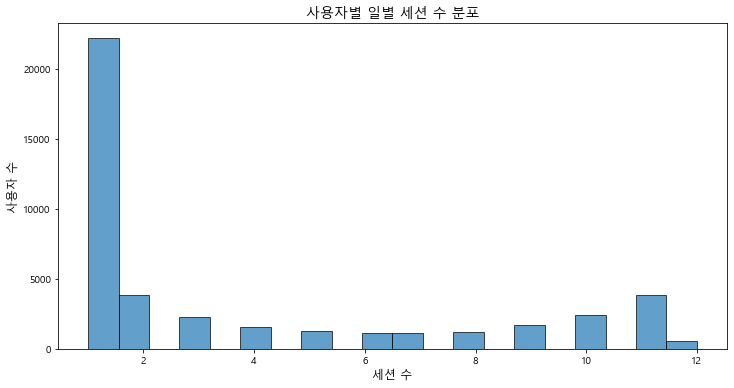


=== 샘플 일별 세션 시퀀스 ===
사용자 1.0 (2025-09-08): RAFFLE -> CHG -> CARD -> STRETCHING -> COUPANG...
사용자 2.0 (2025-09-08): COUPANG -> QUIZ -> CARD -> BUZZVILL...
사용자 2.0 (2025-09-09): STRETCHING -> CARD -> WALK -> RAFFLE -> CHG...
사용자 2.0 (2025-09-11): STRETCHING -> QUIZ -> COUPANG...
사용자 2.0 (2025-09-12): STRETCHING -> QUIZ -> CARD...

=== 날짜별 세션 수 분석 ===
date
2025-09-08    11313
2025-09-09    16142
2025-09-10    15720
2025-09-11    15060
2025-09-12    14814
2025-09-13    13701
2025-09-14    15084
2025-09-15    13767
2025-09-16    14141
2025-09-17    14425
2025-09-18    15880
2025-09-19     2511
dtype: int64


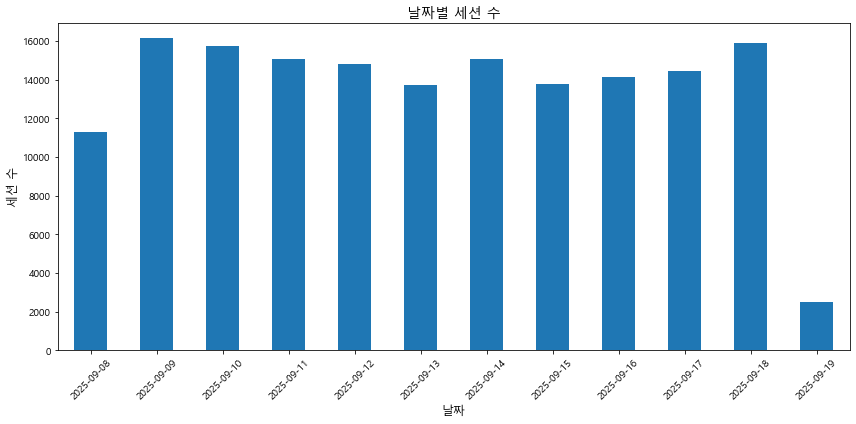


=== 기존 방식 vs 날짜별 분리 방식 비교 ===
기존 방식 (전체 시퀀스): 43,181개
날짜별 분리 방식: 162,558개
차이: 119,377개


In [70]:
# 2. 사용자별 시퀀스 분석 (날짜별 세션 분리)
print("=== 사용자별 시퀀스 분석 (날짜별 세션 분리) ===")

# 사용자별로 이벤트를 시간 순으로 정렬
df_sorted = df.sort_values(['user_seq', 'event_dttm'])

# 날짜별로 세션을 분리하여 시퀀스 생성
def create_daily_sequences(df):
    """날짜별로 세션을 분리하여 시퀀스 생성"""
    sequences = []
    
    for user_id in df['user_seq'].unique():
        user_data = df[df['user_seq'] == user_id].copy()
        
        # 날짜별로 그룹화
        for date in user_data['event_dt'].unique():
            daily_events = user_data[user_data['event_dt'] == date].sort_values('event_dttm')
            
            if len(daily_events) > 0:
                sequence = daily_events['event_type'].tolist()
                sequences.append({
                    'user_seq': user_id,
                    'date': date,
                    'event_sequence': sequence,
                    'sequence_length': len(sequence),
                    'start_time': daily_events['event_dttm'].min(),
                    'end_time': daily_events['event_dttm'].max()
                })
    
    return pd.DataFrame(sequences)

# 날짜별 시퀀스 생성
daily_sequences = create_daily_sequences(df_sorted)

print(f"총 세션 수: {len(daily_sequences):,}")
print(f"고유 사용자 수: {daily_sequences['user_seq'].nunique():,}")
print(f"평균 시퀀스 길이: {daily_sequences['sequence_length'].mean():.2f}")
print(f"최대 시퀀스 길이: {daily_sequences['sequence_length'].max()}")
print(f"최소 시퀀스 길이: {daily_sequences['sequence_length'].min()}")

# 시퀀스 길이 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(daily_sequences['sequence_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('일별 세션 시퀀스 길이 분포', fontsize=14)
plt.xlabel('시퀀스 길이', fontsize=12)
plt.ylabel('세션 수', fontsize=12)
plt.show()

# 시퀀스 길이 통계
print("\n=== 시퀀스 길이 통계 ===")
print(daily_sequences['sequence_length'].describe())

# 사용자별 세션 수 분석
user_session_counts = daily_sequences.groupby('user_seq').size()
print(f"\n=== 사용자별 세션 수 분석 ===")
print(f"평균 세션 수: {user_session_counts.mean():.2f}")
print(f"최대 세션 수: {user_session_counts.max()}")
print(f"최소 세션 수: {user_session_counts.min()}")

# 세션 수 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(user_session_counts, bins=20, alpha=0.7, edgecolor='black')
plt.title('사용자별 일별 세션 수 분포', fontsize=14)
plt.xlabel('세션 수', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.show()

# 몇 개의 샘플 시퀀스 출력
print("\n=== 샘플 일별 세션 시퀀스 ===")
for i in range(5):
    row = daily_sequences.iloc[i]
    print(f"사용자 {row['user_seq']} ({row['date']}): {' -> '.join(row['event_sequence'][:10])}...")

# 날짜별 세션 수 분석
print("\n=== 날짜별 세션 수 분석 ===")
daily_session_counts = daily_sequences.groupby('date').size()
print(daily_session_counts)

# 날짜별 세션 수 시각화
plt.figure(figsize=(12, 6))
daily_session_counts.plot(kind='bar')
plt.title('날짜별 세션 수', fontsize=14)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('세션 수', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 기존 방식과 비교
print("\n=== 기존 방식 vs 날짜별 분리 방식 비교 ===")
print(f"기존 방식 (전체 시퀀스): {len(df_sorted.groupby('user_seq').size()):,}개")
print(f"날짜별 분리 방식: {len(daily_sequences):,}개")
print(f"차이: {len(daily_sequences) - len(df_sorted.groupby('user_seq').size()):,}개")

# user_sequences 변수를 날짜별 시퀀스로 업데이트 (다음 분석에서 사용)
user_sequences = daily_sequences[['user_seq', 'event_sequence']].copy()


In [71]:
# 3. 이벤트 전이 행렬 생성
print("=== 이벤트 전이 행렬 분석 ===")

# 모든 이벤트 타입 수집
all_events = df['event_type'].unique()
transition_counts = pd.DataFrame(0, index=all_events, columns=all_events)

# 각 사용자의 시퀀스에서 전이 카운트
for _, row in user_sequences.iterrows():
    sequence = row['event_sequence']
    for i in range(len(sequence) - 1):
        from_event = sequence[i]
        to_event = sequence[i + 1]
        transition_counts.loc[from_event, to_event] += 1

print("전이 횟수 행렬 (상위 10x10):")
print(transition_counts.iloc[:10, :10])

# 전이 확률 계산
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)
print("\n전이 확률 행렬 (상위 10x10):")
print(transition_probs.iloc[:10, :10].round(3))

# 가장 강한 전이들 찾기
print("\n=== 가장 강한 전이 (상위 10개) ===")
strong_transitions = transition_probs.stack().sort_values(ascending=False)
for i, ((from_event, to_event), prob) in enumerate(strong_transitions.head(10).items()):
    if prob > 0:
        print(f"{i+1}. {from_event} → {to_event}: {prob:.3f}")


=== 이벤트 전이 행렬 분석 ===
전이 횟수 행렬 (상위 10x10):
             QUIZ   CARD  COUPANG  STRETCHING  LIKE  FOLLOW  BUZZVILL   WALK  \
QUIZ            0  19916     3879        1589    13       1        74  16087   
CARD         1204      0     2792        1595    70       6       141   8495   
COUPANG      3950    867        0        2328    21       1       925   5162   
STRETCHING   1302    399     4023           0    11       2       177   1672   
LIKE           17      7       13          17     0      28         5     46   
FOLLOW          6      1        3           2    11       0         1      6   
BUZZVILL       85     43      132         116     5       1         0    226   
WALK        12199   1705     4356        1564    24       5       174      0   
RAFFLE          0      0        0           0     0       0         0      0   
CHG          4749    819     2043         726    23       2        99   9200   

            RAFFLE    CHG  
QUIZ          1709      0  
CARD          1807   

=== 전이 확률 히트맵 ===


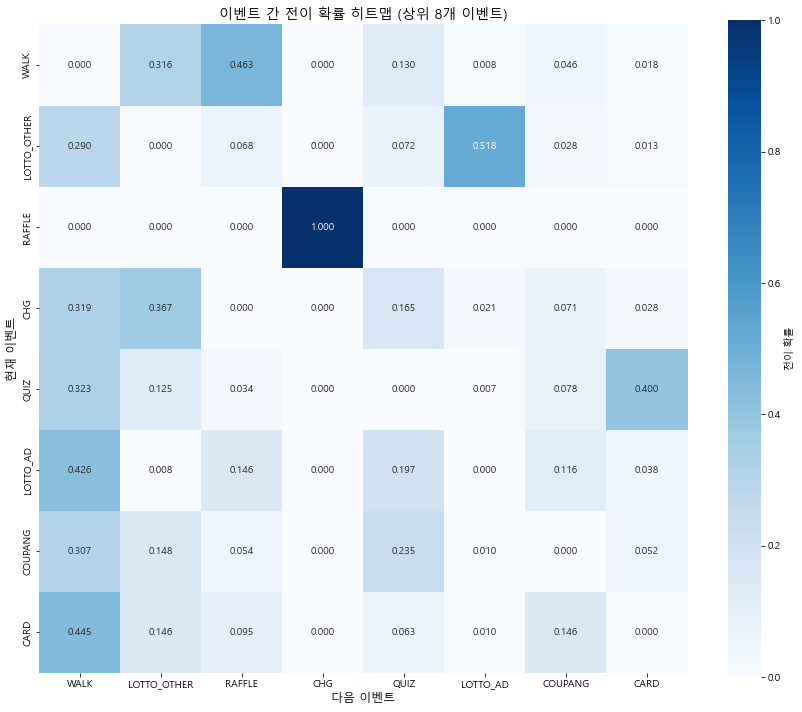

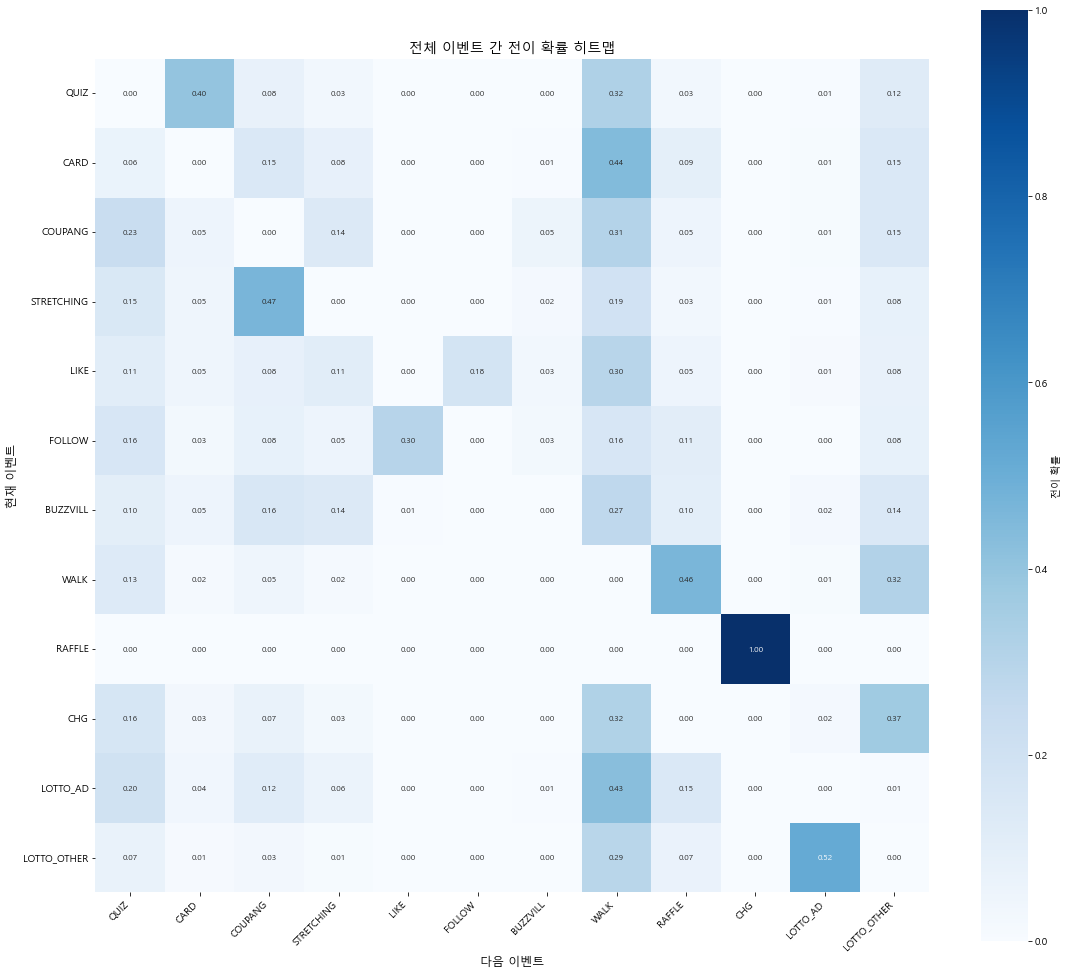

In [72]:
# 4. 전이 확률 히트맵 시각화
print("=== 전이 확률 히트맵 ===")

# 상위 이벤트들만 선택하여 히트맵 생성 (가독성을 위해)
top_events = event_counts.head(8).index
transition_probs_subset = transition_probs.loc[top_events, top_events]

plt.figure(figsize=(12, 10))
sns.heatmap(transition_probs_subset, annot=True, fmt='.3f', cmap='Blues', 
            square=True, cbar_kws={'label': '전이 확률'})
plt.title('이벤트 간 전이 확률 히트맵 (상위 8개 이벤트)', fontsize=14)
plt.xlabel('다음 이벤트', fontsize=12)
plt.ylabel('현재 이벤트', fontsize=12)
plt.tight_layout()
plt.show()

# 전체 전이 행렬 히트맵 (더 작은 폰트로)
plt.figure(figsize=(16, 14))
sns.heatmap(transition_probs, annot=True, fmt='.2f', cmap='Blues', 
            square=True, cbar_kws={'label': '전이 확률'}, 
            annot_kws={'size': 8})
plt.title('전체 이벤트 간 전이 확률 히트맵', fontsize=14)
plt.xlabel('다음 이벤트', fontsize=12)
plt.ylabel('현재 이벤트', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


=== 강화된 이벤트 전이 네트워크 그래프 ===


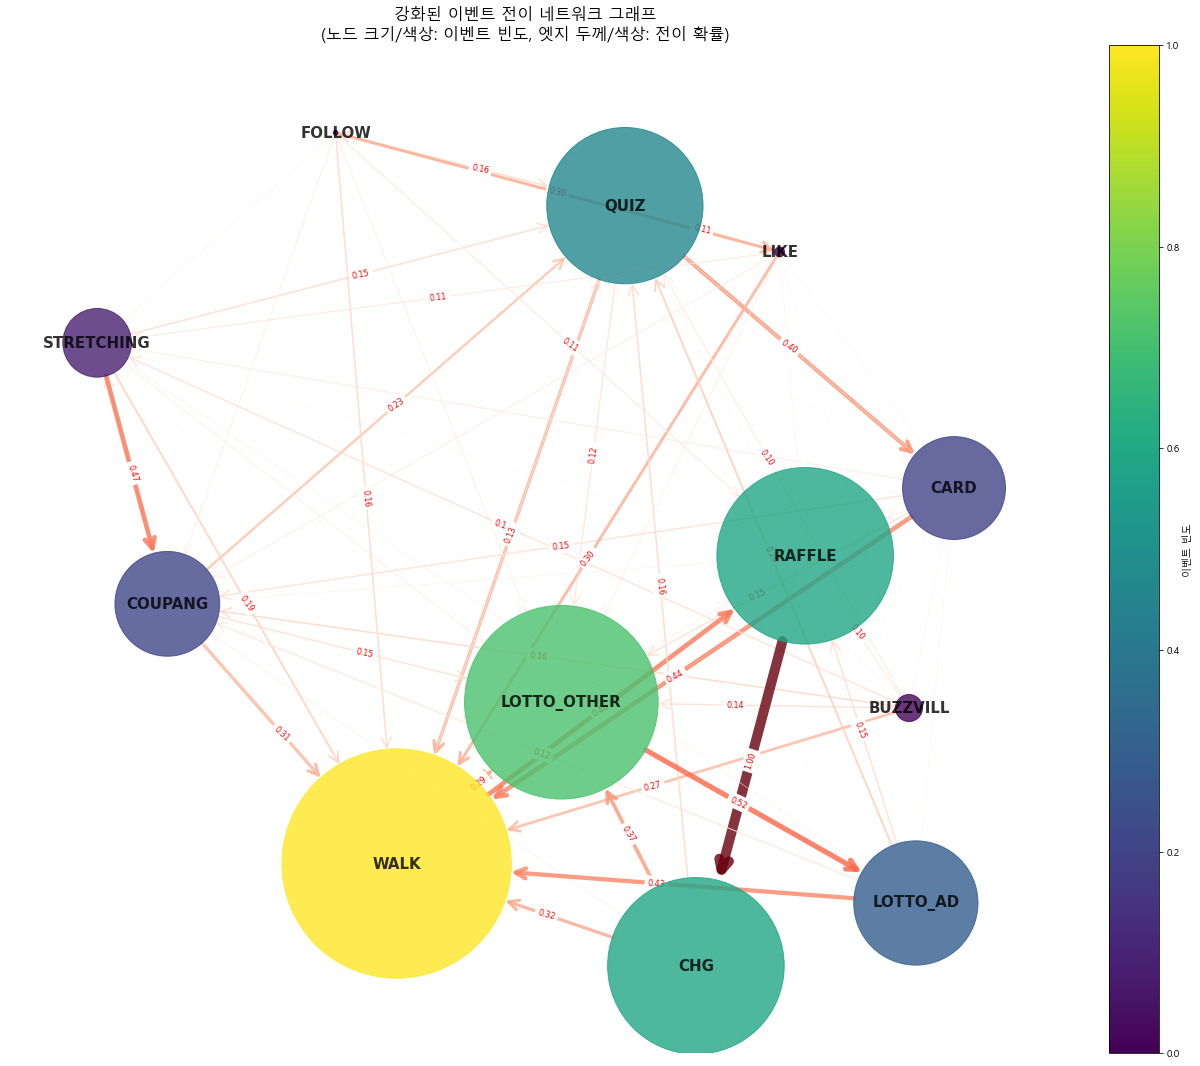


=== 네트워크 분석 ===
총 노드 수: 12
총 엣지 수: 81

나가는 연결 수 상위 5개:
  LIKE: 10개
  FOLLOW: 9개
  BUZZVILL: 8개
  CARD: 7개
  COUPANG: 7개

들어오는 연결 수 상위 5개:
  QUIZ: 10개
  CARD: 10개
  COUPANG: 10개
  STRETCHING: 10개
  WALK: 10개

✅ 강화된 네트워크 그래프 시각화 완료!


In [86]:
# 강화된 네트워크 그래프로 이벤트 전이 시각화
print("=== 강화된 이벤트 전이 네트워크 그래프 ===")

# NetworkX 그래프 생성
G = nx.DiGraph()

# 노드 추가 (이벤트 타입들)
for event in all_events:
    G.add_node(event)

# 엣지 추가 (전이 확률이 0.01보다 큰 경우만, 가독성을 위해)
for from_event in all_events:
    for to_event in all_events:
        prob = transition_probs.loc[from_event, to_event]
        if prob > 0.01:  # 임계값 설정
            G.add_edge(from_event, to_event, weight=prob)

# 강화된 네트워크 그래프 시각화
plt.figure(figsize=(18, 14))

# 레이아웃 최적화
pos = nx.spring_layout(G, k=3, iterations=200, seed=42)

# 노드 크기와 색상 (이벤트 빈도 기반)
node_sizes = [event_counts[event] * 0.4 for event in G.nodes()]
node_colors = [event_counts[event] for event in G.nodes()]

# 엣지 두께와 색상 (전이 확률 기반)
edges = G.edges(data=True)
edge_weights = [edge[2]['weight'] * 10 for edge in edges]
edge_colors = [edge[2]['weight'] for edge in edges]

# 그래프 그리기
nx.draw(G, pos, 
        node_size=node_sizes,
        node_color=node_colors,
        cmap='viridis',
        edge_color=edge_colors,
        edge_cmap=plt.cm.Reds,
        width=edge_weights,
        with_labels=True,
        font_size=15,
        font_weight='bold',
        arrows=True,
        arrowsize=25,
        arrowstyle='->',
        alpha=0.8)

# 엣지 라벨 (전이 확률) 추가
edge_labels = {}
for edge in edges:
    if edge[2]['weight'] > 0.1:  # 5% 이상인 경우만 표시
        edge_labels[(edge[0], edge[1])] = f"{edge[2]['weight']:.2f}"

nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, font_color='red')

plt.title('강화된 이벤트 전이 네트워크 그래프\n(노드 크기/색상: 이벤트 빈도, 엣지 두께/색상: 전이 확률)', fontsize=16)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='이벤트 빈도')
plt.tight_layout()
plt.show()

# 네트워크 분석
print("\n=== 네트워크 분석 ===")
print(f"총 노드 수: {G.number_of_nodes()}")
print(f"총 엣지 수: {G.number_of_edges()}")

# 나가는 연결 수 상위 5개
out_degrees = dict(G.out_degree())
print("\n나가는 연결 수 상위 5개:")
out_degree_sorted = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
for event, degree in out_degree_sorted[:5]:
    print(f"  {event}: {degree}개")

# 들어오는 연결 수 상위 5개
in_degrees = dict(G.in_degree())
print("\n들어오는 연결 수 상위 5개:")
in_degree_sorted = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)
for event, degree in in_degree_sorted[:5]:
    print(f"  {event}: {degree}개")

print("\n✅ 강화된 네트워크 그래프 시각화 완료!")

In [88]:
# 6. 사용자 행동 패턴 분석
print("=== 사용자 행동 패턴 분석 ===")

# 가장 일반적인 시퀀스 패턴 찾기
def get_sequence_patterns(sequences, min_length=2, max_length=4):
    """시퀀스에서 패턴을 추출하는 함수"""
    patterns = []
    for sequence in sequences:
        for length in range(min_length, min(max_length + 1, len(sequence) + 1)):
            for i in range(len(sequence) - length + 1):
                pattern = tuple(sequence[i:i+length])
                patterns.append(pattern)
    return patterns

# 2-4 길이의 패턴 추출
all_sequences = user_sequences['event_sequence'].tolist()
patterns = get_sequence_patterns(all_sequences, min_length=2, max_length=4)

# 패턴 빈도 계산
pattern_counts = Counter(patterns)

print("가장 빈번한 2-길이 패턴 (상위 15개):")
count_2 = 0
for pattern, count in pattern_counts.most_common(50):
    if len(pattern) == 2 and count_2 < 15:
        print(f"{' -> '.join(pattern)}: {count:,}회")
        count_2 += 1

print("\n가장 빈번한 3-길이 패턴 (상위 10개):")
count_3 = 0
for pattern, count in pattern_counts.most_common(100):
    if len(pattern) == 3 and count_3 < 10:
        print(f"{' -> '.join(pattern)}: {count:,}회")
        count_3 += 1

# 특정 이벤트들의 전환 경로 분석
print("\n=== 특정 이벤트 전환 경로 분석 ===")

# LOTTO_OTHER 이벤트 전후 분석
if 'CARD' in df['event_type'].values:
    lotto_sequences = []
    for _, row in user_sequences.iterrows():
        sequence = row['event_sequence']
        if 'CARD' in sequence:
            lotto_idx = sequence.index('CARD')
            # CARD 이전과 이후의 이벤트들
            before_lotto = sequence[:lotto_idx] if lotto_idx > 0 else ['start']
            after_lotto = sequence[lotto_idx+1:] if lotto_idx < len(sequence)-1 else ['end']
            lotto_sequences.append((before_lotto[-1] if before_lotto else 'start', 
                                 'CARD', 
                                 after_lotto[0] if after_lotto else 'end'))
    
    if lotto_sequences:
        print(f"CARD 이벤트를 한 사용자 수: {len(lotto_sequences):,}")
        
        # CARD 이전 이벤트 분석
        before_events = [seq[0] for seq in lotto_sequences]
        before_counts = Counter(before_events)
        print("\nCARD 이전 이벤트:")
        for event, count in before_counts.most_common(5):
            print(f"{event}: {count:,}회 ({count/len(lotto_sequences)*100:.1f}%)")
        
        # CARD 이후 이벤트 분석
        after_events = [seq[2] for seq in lotto_sequences]
        after_counts = Counter(after_events)
        print("\nCARD_OTHER 이후 이벤트:")
        for event, count in after_counts.most_common(5):
            print(f"{event}: {count:,}회 ({count/len(lotto_sequences)*100:.1f}%)")


=== 사용자 행동 패턴 분석 ===
가장 빈번한 2-길이 패턴 (상위 15개):
RAFFLE -> CHG: 77,981회
WALK -> RAFFLE: 43,547회
LOTTO_OTHER -> LOTTO_AD: 36,386회
WALK -> LOTTO_OTHER: 29,761회
LOTTO_OTHER -> WALK: 20,374회
QUIZ -> CARD: 19,916회
QUIZ -> WALK: 16,087회
WALK -> QUIZ: 12,199회
CHG -> LOTTO_OTHER: 10,599회
CHG -> WALK: 9,200회
CARD -> WALK: 8,495회
LOTTO_AD -> WALK: 8,371회
QUIZ -> LOTTO_OTHER: 6,214회
COUPANG -> WALK: 5,162회
LOTTO_OTHER -> QUIZ: 5,053회

가장 빈번한 3-길이 패턴 (상위 10개):
WALK -> RAFFLE -> CHG: 43,547회
RAFFLE -> CHG -> LOTTO_OTHER: 10,599회
WALK -> LOTTO_OTHER -> LOTTO_AD: 9,817회
RAFFLE -> CHG -> WALK: 9,200회
LOTTO_OTHER -> LOTTO_AD -> WALK: 8,200회
QUIZ -> CARD -> WALK: 7,233회
LOTTO_OTHER -> RAFFLE -> CHG: 4,800회
RAFFLE -> CHG -> QUIZ: 4,749회
CHG -> LOTTO_OTHER -> LOTTO_AD: 4,506회
LOTTO_OTHER -> WALK -> RAFFLE: 4,273회

=== 특정 이벤트 전환 경로 분석 ===
CARD 이벤트를 한 사용자 수: 26,483

CARD 이전 이벤트:
QUIZ: 19,916회 (75.2%)
WALK: 1,705회 (6.4%)
start: 1,051회 (4.0%)
LOTTO_OTHER: 927회 (3.5%)
COUPANG: 867회 (3.3%)

CARD_OTHER 이후 이벤트:
WALK

=== 시간대별 이벤트 분석 ===


<Figure size 1152x720 with 0 Axes>

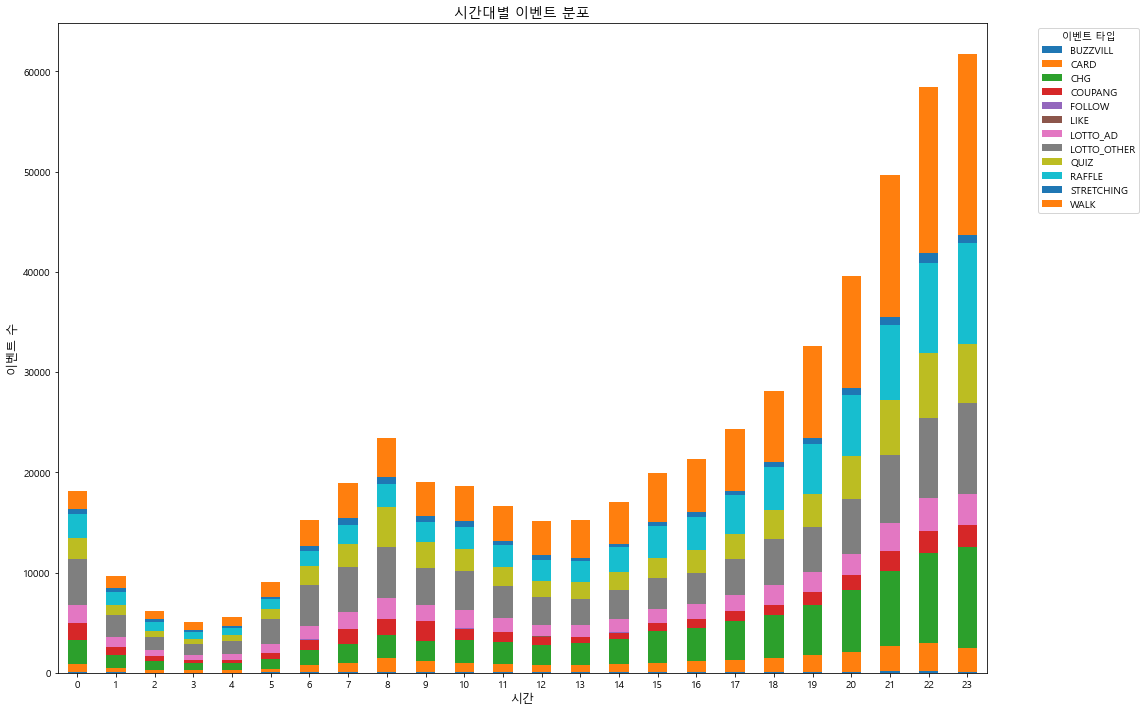

<Figure size 1008x576 with 0 Axes>

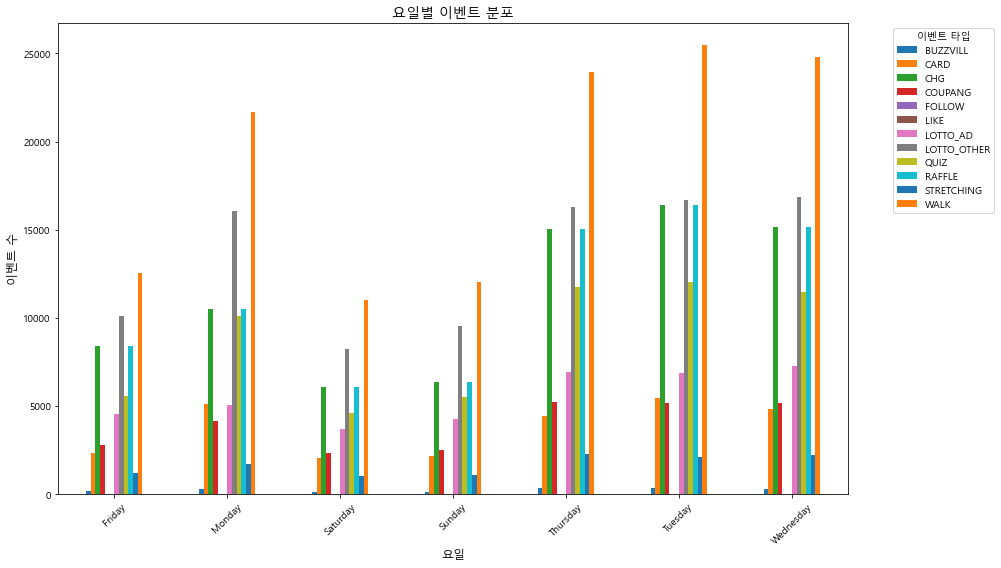

시간대별 이벤트 통계:
가장 활발한 시간대: 23시 (61,776개 이벤트)
가장 조용한 시간대: 3시 (5,032개 이벤트)
평균 시간대별 이벤트 수: 22866


In [75]:
# 7. 시간대별 이벤트 분석
print("=== 시간대별 이벤트 분석 ===")

# 시간대 컬럼 추가
df['hour'] = df['event_dttm'].dt.hour
df['day_of_week'] = df['event_dttm'].dt.day_name()
df['date'] = df['event_dttm'].dt.date

# 시간대별 이벤트 분포
hourly_events = df.groupby('hour')['event_type'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(16, 10))
hourly_events.plot(kind='bar', stacked=True, figsize=(16, 10))
plt.title('시간대별 이벤트 분포', fontsize=14)
plt.xlabel('시간', fontsize=12)
plt.ylabel('이벤트 수', fontsize=12)
plt.legend(title='이벤트 타입', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 요일별 이벤트 분포
daily_events = df.groupby('day_of_week')['event_type'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
daily_events.plot(kind='bar', figsize=(14, 8))
plt.title('요일별 이벤트 분포', fontsize=14)
plt.xlabel('요일', fontsize=12)
plt.ylabel('이벤트 수', fontsize=12)
plt.legend(title='이벤트 타입', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 시간대별 통계
print("시간대별 이벤트 통계:")
hourly_stats = df.groupby('hour').size()
print(f"가장 활발한 시간대: {hourly_stats.idxmax()}시 ({hourly_stats.max():,}개 이벤트)")
print(f"가장 조용한 시간대: {hourly_stats.idxmin()}시 ({hourly_stats.min():,}개 이벤트)")
print(f"평균 시간대별 이벤트 수: {hourly_stats.mean():.0f}")


In [79]:
# 11. 분석 결과 요약 및 인사이트
print("=== 클릭스트림 분석 결과 요약 ===")

print("📊 기본 통계:")
print(f"• 총 이벤트 수: {len(df):,}")
print(f"• 고유 사용자 수: {df['user_seq'].nunique():,}")
print(f"• 이벤트 타입 수: {df['event_type'].nunique()}")
print(f"• 분석 기간: {df['event_dt'].min()} ~ {df['event_dt'].max()}")

print("\n🎯 주요 인사이트:")
print(f"• 가장 빈번한 이벤트: {event_counts.index[0]} ({event_counts.iloc[0]:,}회, {event_counts.iloc[0]/len(df)*100:.1f}%)")
print(f"• 평균 시퀀스 길이: {user_sequences['event_sequence'].apply(len).mean():.1f}")
print(f"• 가장 강한 전이: {transition_probs.stack().idxmax()[0]} → {transition_probs.stack().idxmax()[1]} ({transition_probs.stack().max():.3f})")

print("\n📈 시간대별 패턴:")
peak_hour = df.groupby('hour').size().idxmax()
print(f"• 가장 활발한 시간대: {peak_hour}시")

print("\n🔍 사용자 행동 패턴:")
if len(pattern_counts) > 0:
    most_common_pattern = pattern_counts.most_common(1)[0]
    print(f"• 가장 빈번한 패턴: {' → '.join(most_common_pattern[0])} ({most_common_pattern[1]:,}회)")

print("\n💡 비즈니스 인사이트:")
print(f"• LOTTO_OTHER 사용자 비율: {len(user_lotto)/len(user_stats)*100:.1f}%")
print(f"• RAFFLE 사용자 비율: {len(user_raffle)/len(user_stats)*100:.1f}%")
print(f"• QUIZ 사용자 비율: {len(user_quiz)/len(user_stats)*100:.1f}%")
print(f"• WALK 사용자 비율: {len(user_walk)/len(user_stats)*100:.1f}%")

# 상위 이벤트들의 사용자 참여도
print("\n📊 이벤트별 사용자 참여도:")
for i, (event, count) in enumerate(event_counts.head(5).items()):
    users = df[df['event_type'] == event]['user_seq'].nunique()
    print(f"{i+1}. {event}: {users:,}명 ({users/df['user_seq'].nunique()*100:.1f}%)")

print("\n✅ 분석 완료!")
print("이 분석을 통해 사용자의 행동 패턴, 전환 경로, 시간대별 특성을 파악할 수 있습니다.")
print("추가로 필요한 분석이 있다면 말씀해 주세요!")


=== 클릭스트림 분석 결과 요약 ===
📊 기본 통계:
• 총 이벤트 수: 548,779
• 고유 사용자 수: 43,181
• 이벤트 타입 수: 12
• 분석 기간: 2025-09-08 ~ 2025-09-19

🎯 주요 인사이트:
• 가장 빈번한 이벤트: WALK (131,482회, 24.0%)
• 평균 시퀀스 길이: 3.4
• 가장 강한 전이: RAFFLE → CHG (1.000)

📈 시간대별 패턴:
• 가장 활발한 시간대: 23시

🔍 사용자 행동 패턴:
• 가장 빈번한 패턴: RAFFLE → CHG (77,981회)

💡 비즈니스 인사이트:
• LOTTO_OTHER 사용자 비율: 39.3%
• RAFFLE 사용자 비율: 88.6%
• QUIZ 사용자 비율: 32.8%
• WALK 사용자 비율: 55.9%

📊 이벤트별 사용자 참여도:
1. WALK: 24,138명 (55.9%)
2. LOTTO_OTHER: 16,981명 (39.3%)
3. RAFFLE: 38,268명 (88.6%)
4. CHG: 38,268명 (88.6%)
5. QUIZ: 14,151명 (32.8%)

✅ 분석 완료!
이 분석을 통해 사용자의 행동 패턴, 전환 경로, 시간대별 특성을 파악할 수 있습니다.
추가로 필요한 분석이 있다면 말씀해 주세요!


In [92]:
transition_probs_subset

event_type,WALK,LOTTO_OTHER,RAFFLE,CHG,QUIZ,LOTTO_AD,COUPANG,CARD,STRETCHING,BUZZVILL,LIKE,FOLLOW
event_type,,,,,,,,,,,,
WALK,0.000000,0.316297,0.462813,0.0,0.129650,0.008045,0.046295,0.018121,0.016622,0.001849,0.000255,0.000053
LOTTO_OTHER,0.289819,0.000000,0.068280,0.0,0.071879,0.517589,0.027838,0.013187,0.010384,0.000882,0.000128,0.000014
RAFFLE,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHG,0.318780,0.367256,0.000000,0.0,0.164553,0.020790,0.070790,0.028378,0.025156,0.003430,0.000797,0.000069
QUIZ,0.322902,0.124729,0.034303,0.0,0.000000,0.006784,0.077860,0.399759,0.031895,0.001485,0.000261,0.000020
LOTTO_AD,0.426287,0.007588,0.145643,0.0,0.196771,0.000000,0.116158,0.038091,0.061720,0.006722,0.000968,0.000051
COUPANG,0.306824,0.148241,0.054387,0.0,0.234784,0.009570,0.000000,0.051534,0.138374,0.054981,0.001248,0.000059
CARD,0.444741,0.146327,0.094602,0.0,0.063033,0.010261,0.146170,0.000000,0.083503,0.007382,0.003665,0.000314
STRETCHING,0.194736,0.078150,0.031330,0.0,0.151642,0.006988,0.468553,0.046471,0.000000,0.020615,0.001281,0.000233


In [93]:
pattern_3_probs

{('WALK', 'LOTTO_OTHER', 'WALK'): {'probability': 0.0,
  'count': 0,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'LOTTO_OTHER'): {'probability': 0.0,
  'count': 0,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'RAFFLE'): {'probability': 0.08756772587494509,
  'count': 1196,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'CHG'): {'probability': 0.0,
  'count': 0,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'QUIZ'): {'probability': 0.10733635964270025,
  'count': 1466,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'LOTTO_AD'): {'probability': 0.7187728803631571,
  'count': 9817,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'COUPANG'): {'probability': 0.05022697320251867,
  'count': 686,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'CARD'): {'probability': 0.01603455850051252,
  'count': 219,
  'total_from_middle': 13658},
 ('WALK', 'LOTTO_OTHER', 'STRETCHING'): {'probability': 0.018304290525699225,
  'count': 250,

=== 시퀀스 확률 표 정리 ===

📊 2-길이 시퀀스 확률 표 (A→B)
From         To           Probability  Count   
------------------------------------------------------------
WALK         LOTTO_OTHER  0.316        29761   
WALK         RAFFLE       0.463        43547   
WALK         QUIZ         0.130        12199   
WALK         LOTTO_AD     0.008        757     
WALK         COUPANG      0.046        4356    
WALK         CARD         0.018        1705    
WALK         STRETCHING   0.017        1564    
WALK         BUZZVILL     0.002        174     
WALK         LIKE         0.000        24      
WALK         FOLLOW       0.000        5       
LOTTO_OTHER  WALK         0.290        20374   
LOTTO_OTHER  RAFFLE       0.068        4800    
LOTTO_OTHER  QUIZ         0.072        5053    
LOTTO_OTHER  LOTTO_AD     0.518        36386   
LOTTO_OTHER  COUPANG      0.028        1957    
LOTTO_OTHER  CARD         0.013        927     
LOTTO_OTHER  STRETCHING   0.010        730     
LOTTO_OTHER  BUZZVILL     0.001 

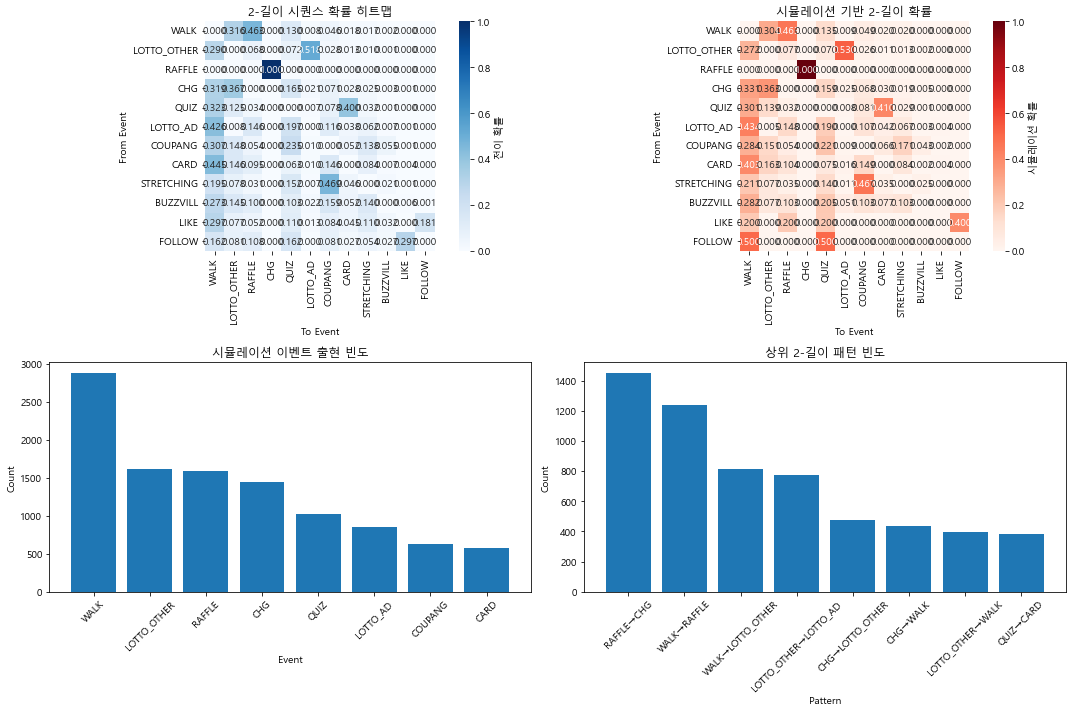


✅ 시퀀스 확률 표 정리 완료!


In [95]:
# 13. 시퀀스 확률 표 정리
print("=== 시퀀스 확률 표 정리 ===")

# 1. 2-길이 시퀀스 (A→B) 확률 표
print("\n📊 2-길이 시퀀스 확률 표 (A→B)")
print("=" * 60)

# 전이 확률 행렬에서 상위 이벤트들만 선택
top_events = event_counts.head(20).index
transition_probs_subset = transition_probs.loc[top_events, top_events]

# 2-길이 시퀀스 확률 표 생성
print(f"{'From':<12} {'To':<12} {'Probability':<12} {'Count':<8}")
print("-" * 60)

for from_event in top_events:
    for to_event in top_events:
        prob = transition_probs_subset.loc[from_event, to_event]
        if prob > 0:  # 확률이 0보다 큰 경우만 표시
            count = transition_counts.loc[from_event, to_event]
            print(f"{from_event:<12} {to_event:<12} {prob:<12.3f} {count:<8}")

# 2. 3-길이 시퀀스 (A→B→C) 확률 표
print("\n📊 3-길이 시퀀스 확률 표 (A→B→C)")
print("=" * 80)

# 3-길이 패턴 확률 계산
def calculate_3_length_probabilities(sequences, top_events):
    """3-길이 시퀀스 확률 계산"""
    pattern_probs = {}
    
    for from_event in top_events:
        for middle_event in top_events:
            for to_event in top_events:
                pattern = (from_event, middle_event, to_event)
                
                # 해당 패턴의 출현 횟수 계산
                count = 0
                total_from_middle = 0
                
                for seq in sequences:
                    for i in range(len(seq) - 2):
                        if seq[i] == from_event and seq[i+1] == middle_event:
                            total_from_middle += 1
                            if seq[i+2] == to_event:
                                count += 1
                
                if total_from_middle > 0:
                    prob = count / total_from_middle
                    pattern_probs[pattern] = {
                        'probability': prob,
                        'count': count,
                        'total_from_middle': total_from_middle
                    }
    
    return pattern_probs

# 실제 데이터에서 3-길이 확률 계산
pattern_3_probs = calculate_3_length_probabilities(user_sequences['event_sequence'].tolist(), top_events)

print(f"{'From':<12} {'Middle':<12} {'To':<12} {'Probability':<12} {'Count':<8} {'Total':<8}")
print("-" * 80)

# 확률 순으로 정렬하여 표시
sorted_patterns = sorted(pattern_3_probs.items(), key=lambda x: x[1]['probability'], reverse=True)

for pattern, data in sorted_patterns[:20]:  # 상위 20개만 표시
    from_event, middle_event, to_event = pattern
    prob = data['probability']
    count = data['count']
    total = data['total_from_middle']
    
    if prob > 0:
        print(f"{from_event:<12} {middle_event:<12} {to_event:<12} {prob:<12.3f} {count:<8} {total:<8}")

# 3. 시뮬레이션 결과 기반 확률 표
print("\n📊 시뮬레이션 기반 시퀀스 확률 표")
print("=" * 60)

# 시뮬레이션에서 2-길이 패턴 확률
print("2-길이 패턴 (시뮬레이션 결과):")
print(f"{'Pattern':<20} {'Count':<8} {'Probability':<12}")
print("-" * 50)

for pattern, count in pattern_2_counts.most_common(15):
    prob = count / len(patterns_2) * 100
    pattern_str = f"{pattern[0]} → {pattern[1]}"
    print(f"{pattern_str:<20} {count:<8} {prob:<12.2f}%")

# 시뮬레이션에서 3-길이 패턴 확률
print("\n3-길이 패턴 (시뮬레이션 결과):")
print(f"{'Pattern':<30} {'Count':<8} {'Probability':<12}")
print("-" * 60)

for pattern, count in pattern_3_counts.most_common(15):
    prob = count / len(patterns_3) * 100
    pattern_str = f"{pattern[0]} → {pattern[1]} → {pattern[2]}"
    print(f"{pattern_str:<30} {count:<8} {prob:<12.2f}%")

# 4. 특정 이벤트에서 시작하는 시퀀스 확률
print("\n📊 특정 이벤트 시작 시퀀스 확률")
print("=" * 50)

start_events = ['WALK', 'LOTTO_OTHER', 'RAFFLE', 'QUIZ']
for start_event in start_events:
    if start_event in top_events:
        print(f"\n{start_event}에서 시작하는 시퀀스:")
        print(f"{'Next Event':<15} {'Probability':<12} {'Count':<8}")
        print("-" * 40)
        
        # 해당 이벤트에서의 전이 확률
        next_events = transition_probs_subset.loc[start_event].sort_values(ascending=False)
        for next_event, prob in next_events.items():
            if prob > 0:
                count = transition_counts.loc[start_event, next_event]
                print(f"{next_event:<15} {prob:<12.3f} {count:<8}")

# 5. 시퀀스 확률 히트맵
print("\n📊 시퀀스 확률 히트맵")
print("=" * 40)

# 2-길이 시퀀스 확률 히트맵
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.heatmap(transition_probs_subset, annot=True, fmt='.3f', cmap='Blues', 
            square=True, cbar_kws={'label': '전이 확률'})
plt.title('2-길이 시퀀스 확률 히트맵')
plt.xlabel('To Event')
plt.ylabel('From Event')

# 시뮬레이션 결과 히트맵
plt.subplot(2, 2, 2)
# 시뮬레이션 결과를 행렬 형태로 변환
sim_matrix = pd.DataFrame(0, index=top_events, columns=top_events)
for pattern, count in pattern_2_counts.items():
    if pattern[0] in top_events and pattern[1] in top_events:
        sim_matrix.loc[pattern[0], pattern[1]] = count

# 확률로 변환
sim_prob_matrix = sim_matrix.div(sim_matrix.sum(axis=1), axis=0).fillna(0)
sns.heatmap(sim_prob_matrix, annot=True, fmt='.3f', cmap='Reds', 
            square=True, cbar_kws={'label': '시뮬레이션 확률'})
plt.title('시뮬레이션 기반 2-길이 확률')
plt.xlabel('To Event')
plt.ylabel('From Event')

# 이벤트 출현 빈도
plt.subplot(2, 2, 3)
event_names = [event for event, _ in event_simulation_counts.most_common(8)]
event_counts_sim = [count for _, count in event_simulation_counts.most_common(8)]
plt.bar(event_names, event_counts_sim)
plt.title('시뮬레이션 이벤트 출현 빈도')
plt.xlabel('Event')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 패턴 빈도
plt.subplot(2, 2, 4)
top_patterns = [f"{p[0]}→{p[1]}" for p, _ in pattern_2_counts.most_common(8)]
top_pattern_counts = [count for _, count in pattern_2_counts.most_common(8)]
plt.bar(range(len(top_patterns)), top_pattern_counts)
plt.title('상위 2-길이 패턴 빈도')
plt.xlabel('Pattern')
plt.ylabel('Count')
plt.xticks(range(len(top_patterns)), top_patterns, rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ 시퀀스 확률 표 정리 완료!")
